# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [2]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [3]:
MODEL = 'lstm'
MODE = 'classification'
FEATURES = ['Trend', 'Log Close', 'Volume', 'Daily Returns Percent']
CLASSES = ['down', 'up']

LEARNING_RATE = 0.0001 if MODEL == 'lstm' else 0.0001
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

SEQ_LEN = 14
BATCH_SIZE = 8
HIDDEN_SIZE = 4
NUM_LAYERS = 1

NUM_EPOCHS = 1000

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [5]:
aapl = load_complete_time_series(REAL_DATA_FOLDER / "AAPL_complete.csv")

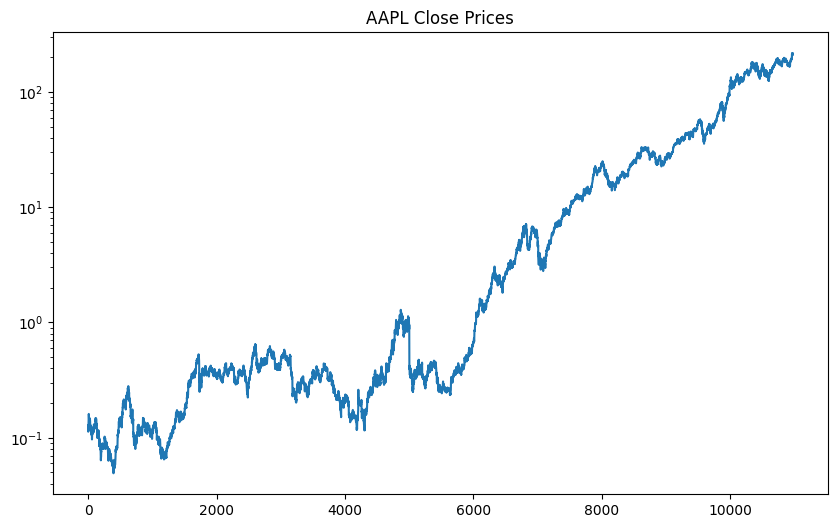

In [6]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'])
plt.yscale('log')
plt.title('AAPL Close Prices')
plt.show()

In [7]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
aapl['Daily Returns Percent'] = aapl['Close'].pct_change()

In [8]:
# get log values
aapl['Log Close'] = np.log(aapl['Close'])

In [9]:
# set trend to 1 if daily return > 1, else -1
aapl['Trend'] = aapl['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
aapl = aapl.dropna()
aapl = aapl[FEATURES]

In [11]:
aapl.head()

,Trend,Log Close,Volume,Daily Returns Percent
1,0,-2.106591,175884800,-0.052171
2,0,-2.182822,105728000,-0.073398
3,1,-2.158372,86441600,0.024751
4,1,-2.129792,73449600,0.028992
5,1,-2.070553,48630400,0.061029


In [12]:
aapl_np = aapl.to_numpy()

In [13]:
aapl_train, aapl_test = train_test_split(aapl_np, FIRST_SPLIT)
aapl_test, aapl_val = train_test_split(aapl_test, SECOND_SPLIT)

In [14]:
aapl_test_dummy = split_data_into_sequences(aapl_test, SEQ_LEN)

Shape of the data after splitting into sequences: (1085, 14, 4)


In [15]:
scaler = Scaler(aapl_train)

In [16]:
aapl_train_scaled = scaler.scale_data(aapl_train)
aapl_test_scaled = scaler.scale_data(aapl_test)
aapl_val_scaled = scaler.scale_data(aapl_val)

In [17]:
aapl_train_seq_scaled = split_data_into_sequences(aapl_train_scaled, SEQ_LEN)
aapl_test_seq_scaled = split_data_into_sequences(aapl_test_scaled, SEQ_LEN)
aapl_val_seq_scaled = split_data_into_sequences(aapl_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (8768, 14, 4)
Shape of the data after splitting into sequences: (1085, 14, 4)
Shape of the data after splitting into sequences: (1085, 14, 4)


In [18]:
aapl_train_seq_scaled[0]

array([[0.        , 0.1391822 , 0.02369891, 0.09644285],
       [0.        , 0.12748639, 0.01424591, 0.04655351],
       [1.        , 0.13123759, 0.01164724, 0.27722803],
       [1.        , 0.13562251, 0.00989668, 0.28719656],
       [1.        , 0.1447113 , 0.00655251, 0.36249006],
       [1.        , 0.15200243, 0.00503436, 0.33344264],
       [1.        , 0.15834398, 0.00632615, 0.31823562],
       [1.        , 0.16621319, 0.006468  , 0.3427465 ],
       [1.        , 0.17975972, 0.00748816, 0.4360062 ],
       [1.        , 0.18190544, 0.0125527 , 0.25215714],
       [0.        , 0.17813051, 0.00928097, 0.16193644],
       [0.        , 0.17369942, 0.00481705, 0.15215024],
       [1.        , 0.17537611, 0.0029186 , 0.24488233],
       [0.        , 0.1720042 , 0.00481403, 0.16796795]])

In [19]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(aapl_train_seq_scaled, aapl_test_seq_scaled, aapl_val_seq_scaled)

In [20]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [22]:
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()
criterion_binary_logits = nn.BCEWithLogitsLoss()
criterion_binary = nn.BCELoss()

In [23]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []
validation_loss_accumulation_callback = ValidationLossAccumulationCallback(val_losses)

In [24]:
X_train.reshape((X_train.shape[0], -1)).shape, y_train.shape

(torch.Size([8768, 39]), torch.Size([8768, 1]))

In [25]:
if MODEL == 'lstm':

    model = LSTMRegression(
        device=device,
        input_size=X_train.shape[2], # number of features
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion_binary_logits,
                        optimizer=optimizer,
                        device=device)
    
elif MODEL == 'xgb':

    model = XGBClassifier(
        objective='binary:logistic',      
        max_depth=10,       
        learning_rate=0.00005,
        n_estimators=1000,
        verbosity=2,
        early_stopping_rounds=10,
        callbacks=[validation_loss_accumulation_callback], 
        reg_alpha=0.01,
        reg_lambda=0.01
    )
    
    model.fit(
        X_train.reshape((X_train.shape[0], -1)), 
        y_train,
        eval_set=[(X_val.reshape((X_val.shape[0], -1)), y_val)]
    )

Epoch: 1
Validation Loss: 0.7074999563834247
Validation Accuracy: 52.54183569979716
**************************************************
Epoch: 2
Validation Loss: 0.7032179727273828
Validation Accuracy: 52.5323275862069
**************************************************
Epoch: 3
Validation Loss: 0.6995421893456403
Validation Accuracy: 52.589376267748484
**************************************************
Epoch: 4
Validation Loss: 0.6966100896106047
Validation Accuracy: 52.54183569979716
**************************************************
Epoch: 5
Validation Loss: 0.6941159016945783
Validation Accuracy: 52.51331135902637
**************************************************
Epoch: 6
Validation Loss: 0.6925797935794381
Validation Accuracy: 52.52281947261663
**************************************************
Epoch: 7
Validation Loss: 0.6920009868986466
Validation Accuracy: 52.5323275862069
**************************************************
Epoch: 8
Validation Loss: 0.6919268878067241
Validation 

Text(0.5, 1.0, 'Validation Accuracy')

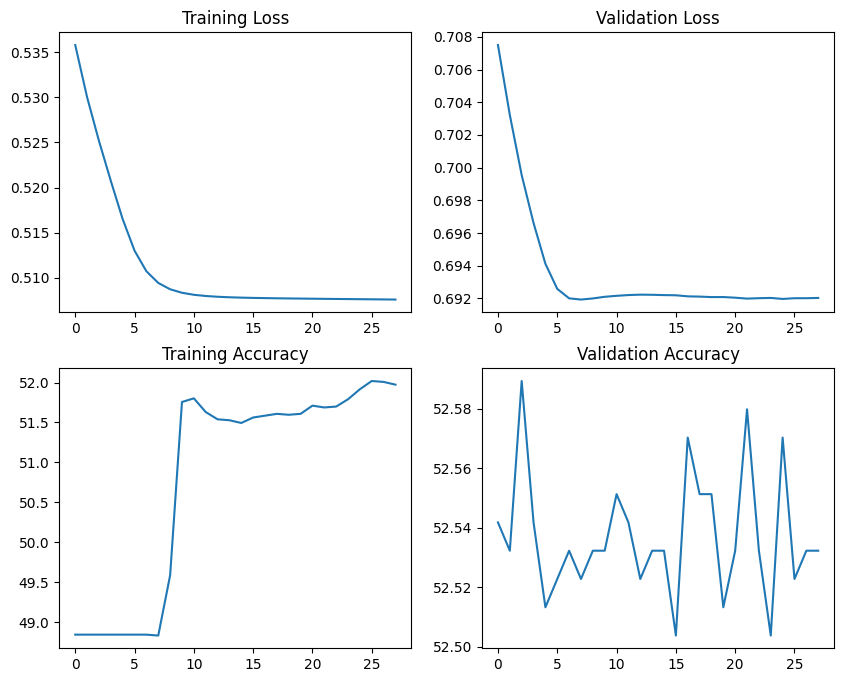

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

## Evaluation

In [28]:
if MODEL == 'lstm':

    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes
        train_logits = model(X_train.to(device))
        train_probs = torch.sigmoid(train_logits)
        train_preds = torch.round(train_probs)

elif MODEL == 'xgb':
        
    test_preds = model.predict(X_test.reshape((X_test.shape[0], -1)))
    train_preds = model.predict(X_train.reshape((X_train.shape[0], -1)))

In [29]:
if MODE == 'regression':
    test_logits = scaler.inverse_scale_data(test_logits, feature_type='price')
    train_logits = scaler.inverse_scale_data(train_logits, feature_type='price')
    y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
    y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

elif MODE == 'classification':
    accuracy(y_true=y_test.flatten(), y_pred=torch.tensor(test_preds))

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_28092/2978573850.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accuracy(y_true=y_test.flatten(), y_pred=torch.tensor(test_preds))


In [30]:
# mean absolute error of only zeros
loss = criterion_absolute(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()
loss

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_28092/2105286845.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()


0.5364055037498474

In [31]:
test_range = (0, 50)
train_range = (0, len(y_train))

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_28092/2477743262.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(test_logits), torch.tensor(y_test)).item()


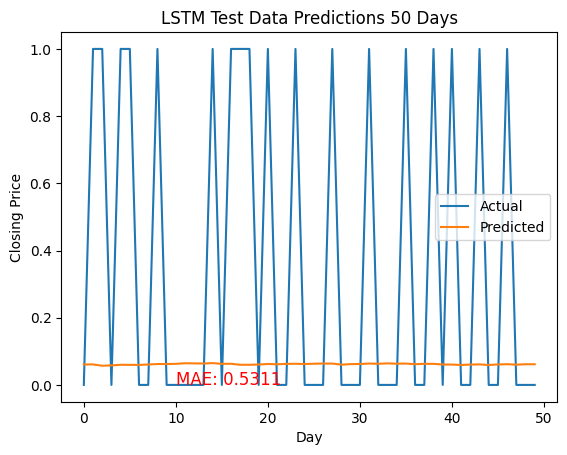

In [32]:
# mean absolute error of test data predictions
loss = criterion_absolute(torch.tensor(test_logits), torch.tensor(y_test)).item()
loss

# plot test data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Test Data Predictions {test_range[1]-test_range[0]} Days')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(np.roll(test_logits[test_range[0]: test_range[1]], 0), label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.legend()
plt.show()

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_28092/1546953015.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(train_logits), torch.tensor(y_train)).item()


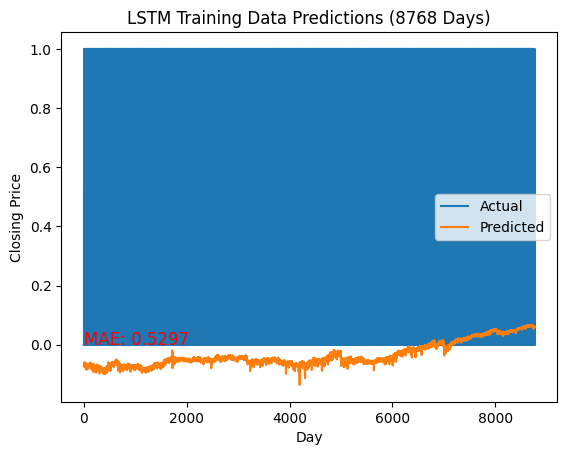

In [33]:
# mean absolute error of training data predictions
loss = criterion_absolute(torch.tensor(train_logits), torch.tensor(y_train)).item()
loss

# plot train data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Training Data Predictions ({train_range[1]-train_range[0]} Days)')
plt.plot(y_train[train_range[0]: train_range[1]], label="Actual")
plt.plot(train_logits[train_range[0]: train_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_train[train_range[0]: train_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

In [34]:
y_train[7000]

tensor([1.])

### dummy testing

In [35]:
dummy = MeanRegressor()

In [36]:
dummy_preds = dummy.make_predictions(aapl_test_dummy, returns=True if 'Daily Returns' in FEATURES else False)

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_28092/2832236691.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1085, 1])) that is different to the input size (torch.Size([1085])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


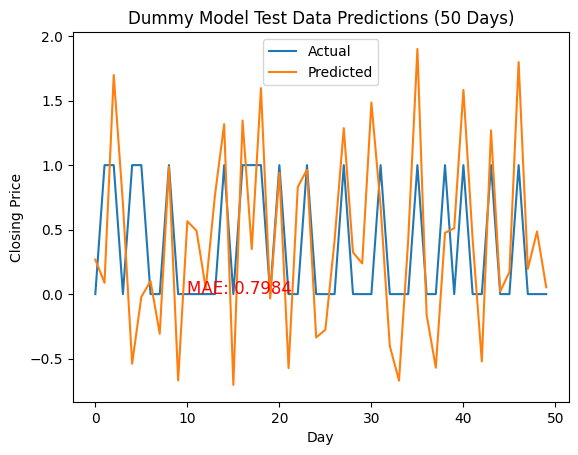

In [37]:
loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
loss

# plot train data
plt.title(f'Dummy Model Test Data Predictions ({test_range[1]-test_range[0]} Days)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(dummy_preds[test_range[0]: test_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

## MAE and MSE Loss experiments

In [38]:
# real = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# A = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 12])
# B = np.array([1, 2.1, 3.1, 4.1, 5.1, 6, 7, 8, 9, 10])

# # scale
# scaler = MinMaxScaler(feature_range=(0, 1))
# real_scaled = scaler.fit_transform(real.reshape(-1, 1))
# A_scaled = scaler.fit_transform(A.reshape(-1, 1))
# B_scaled = scaler.fit_transform(B.reshape(-1, 1))

# loss_MSE = torch.nn.MSELoss()
# loss_MAE = torch.nn.L1Loss()

# MSE_A = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(A_scaled, dtype=torch.float32))
# MAE_A = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(A, dtype=torch.float32))
# MSE_B = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(B_scaled, dtype=torch.float32))
# MAE_B = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(B, dtype=torch.float32))

# print(f'MSE_A: {MSE_A}\n')
# print(f'MAE_A: {MAE_A}\n')
# print(f'MSE_B: {MSE_B}\n')
# print(f'MAE_B: {MAE_B}\n')